In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

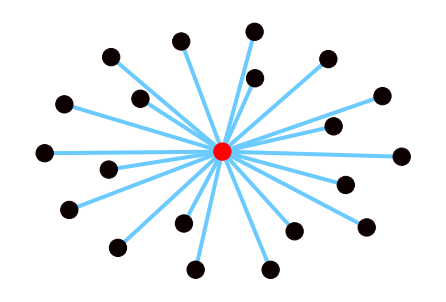

In [8]:
G_star = nx.star_graph(20)
pos2 = nx.spring_layout(G_star, seed=63)  # Seed layout for reproducibility
colors = range(20)
node_color = []
degree_dist = np.array(G_star.degree())[:,1]
for i_node in G_star.nodes():
    node_color.append((degree_dist[i_node]/degree_dist.max(),0,0))
options = {
    "node_color": node_color, #"#A0CBE2",
    "edge_color": "#6BCBFF",
    "width": 4,
    "edge_cmap": plt.cm.Blues,
    "with_labels": False,
}
nx.draw(G_star, pos2, **options)
plt.show()

In [9]:
G2B = G_star.copy()
pos2B = pos2
pAddWire = 0.02
pCutWire = 0.1
# randomly add some edges
for node_i in G2B.nodes:
    for node_j in G2B.nodes:
#         print("node: " + str(node_i) + ", node: ", str(node_j), "has edge: ", G2B.has_edge(node_i,node_j))
        if(G2B.has_edge(node_i,node_j) & (np.random.rand() < pCutWire) & ((G2B.degree[node_i] + G2B.degree[node_j]) > 2) ):
            G2B.remove_edge(node_i,node_j)
            print("Edge removed between " + str(node_i) + ", ", str(node_j))
        if(np.random.rand() < pAddWire):
            G2B.add_edge(node_i,node_j)
            print("Edge added between " + str(node_i) + ", ", str(node_j))
#         print("node: " + str(node_i) + ", node: ", str(node_j), "has edge: ", G2B.has_edge(node_i,node_j))

Edge removed between 0,  5
Edge removed between 0,  6
Edge removed between 0,  8
Edge removed between 0,  17
Edge added between 1,  18
Edge removed between 3,  0
Edge added between 7,  11
Edge added between 13,  8
Edge added between 14,  16
Edge added between 15,  11
Edge added between 16,  4
Edge removed between 18,  0
Edge removed between 18,  1


In [10]:
def get_updated_central_graph_with_random_edges(n_nodes=100, p_add_wire=0.0, p_cut_wire=0.0):
    G_star = nx.star_graph(n_nodes-1)
    for node_i in G_star.nodes:
        for node_j in G_star.nodes:
            if node_i == node_j:
                continue
            if(p_add_wire>0):
                if(np.random.rand() < p_add_wire):
                    G_star.add_edge(node_i,node_j)
                    # print("Edge added between " + str(node_i) + ", ", str(node_j))
            if(p_cut_wire>0):
                if(G_star.has_edge(node_i,node_j) & (np.random.rand() < p_cut_wire) & ((G_star.degree[node_i] + G_star.degree[node_j]) > 2) ):
                    G_star.remove_edge(node_i,node_j)
                    # print("Edge removed between " + str(node_i) + ", ", str(node_j))

    return G_star        


# adding edges based on a random matrix
def get_updated_central_graph_with_random_edges_type_2(n_nodes=100, p_add_wire=0.0, p_cut_wire=0.0):
    G_star = nx.star_graph(n_nodes-1)
    mat_pot_add_edge = np.random.rand(n_nodes,n_nodes) 
    # remove the diagonal elements
    mat_pot_add_edge = mat_pot_add_edge - np.diag(np.diag(mat_pot_add_edge))
    
    mat_pot_add_edge = mat_pot_add_edge < p_add_wire

    for node_i in G_star.nodes:
        for node_j in G_star.nodes:
            if node_i == node_j:
                continue
            if(p_add_wire>0): # do not add edge if p_add_wire is 0
                if(mat_pot_add_edge[node_i,node_j]):
                    G_star.add_edge(node_i,node_j)
                    # print("Edge added between " + str(node_i) + ", ", str(node_j))
            if(p_cut_wire>0):
                if(G_star.has_edge(node_i,node_j) & (np.random.rand() < p_cut_wire) & ((G_star.degree[node_i] + G_star.degree[node_j]) > 2) ):
                    G_star.remove_edge(node_i,node_j)
                    # print("Edge removed between " + str(node_i) + ", ", str(node_j))

    return G_star   


# using matrices. Add edges based on the mat, remove the edges based on a scaled probability
def get_updated_central_graph_with_random_edges_type_3(n_nodes=100, p_add_wire=0.0, p_cut_wire=0.0):
    adjc = np.zeros((n_nodes,n_nodes))
    adjc[0,1:] = 1 # making it a star graph
    adjc = adjc + adjc.T # making it symmetric

    # print("mean degree is: ", np.sum(adjc)/n_nodes)

    # create a random matrix for adding edges
    mat_pot_add_edge = np.random.rand(n_nodes,n_nodes) 
    # make it symmetric
    mat_pot_add_edge = (mat_pot_add_edge + mat_pot_add_edge.T)/2
    # remove the diagonal elements
    mat_pot_add_edge = mat_pot_add_edge + np.eye(n_nodes)
    # the edges with random variable greater than p_add_wire will be added
    adding_link = mat_pot_add_edge < p_add_wire

    # print(adding_link)

    adjc = adjc + adding_link

    # check if adjc is not more than 1  
    adjc = adjc > 0
    
    p_cut_wire_scaled = p_cut_wire / ( (np.sum(adjc)/n_nodes) /n_nodes) 
    print("p_cut_wire_scaled: ", p_cut_wire_scaled, " mean_adjc: ", np.mean(adjc))
    for node_i in range(n_nodes):
        for node_j in range(n_nodes):
            if node_i == node_j:
                continue
            if(p_cut_wire>0):
                if(adjc[node_i,node_j] & (np.random.rand() < p_cut_wire_scaled)): # & ((G_star.degree[node_i] + G_star.degree[node_j]) > 2) ):
                    adjc[node_i,node_j] = 0
                    # print("Edge removed between " + str(node_i) + ", ", str(node_j))

    # make adjc symmetric
    adjc = adjc + adjc.T
    G = nx.from_numpy_array(adjc)

    return G


# using matrices. Add edges based on the mat, remove the edges based on a the number of edges needed to be removed
# # Issue: the giant component size is not fixed
def get_updated_central_graph_with_random_edges_type_4(n_nodes=100, p_change=0.0):
    # make a warning if p_change is greater than 1
    if(p_change>1):
        print("WARNING!! p_change is greater than 1. It is set to 1.")
        p_change = 1
    
    adjc = np.zeros((n_nodes,n_nodes))
    adjc[0,1:] = 1 # making it a star graph
    adjc = adjc + adjc.T # making it symmetric

    # print("0: mean degree is: ", np.sum(adjc)/n_nodes)
    # print("0: sum all adding links: ", np.sum(adjc))

    # create a random matrix for adding edges
    mat_pot_add_edge = np.random.rand(n_nodes,n_nodes) 
    #    # make it symmetric
    #    # mat_pot_add_edge = (mat_pot_add_edge + mat_pot_add_edge.T)/2
    
    # make the lower triangle of mat_potential_add_edge zero
    mat_pot_add_edge = np.triu(mat_pot_add_edge, 1)

    # make sure that the diagonal elements are not selected to be added => the value is zero
    mat_pot_add_edge = mat_pot_add_edge + np.zeros(n_nodes)

    # the edges with random variable greater than (1-p_change) will be added
    adding_link = mat_pot_add_edge > (1-p_change)
    adding_link = adding_link + adding_link.T

    # print("1: sum all adding links: ", np.sum(adding_link))

    # # Second approach

    # compare the adding_link with adjc, and see how many edges should be added
    # make a difference of the two matrices
    new_links_mat = np.logical_and(adding_link, np.logical_not(adjc))

    # calculate number of edges to be removed, based on the adding links and the number of mutual links
    # it should be divided by 2, because the removing_link will be forced to be symmetric
    n_edges_to_be_removed = int(np.sum(new_links_mat)/2)

    # print("2: new adding links: ", np.sum(new_links_mat), ", n_edges_to_be_removed: ", n_edges_to_be_removed)

    # update the adjc by adding the new links
    # adjc = np.logical_or(adjc, adding_link)
    adjc = adjc + new_links_mat

    # print("3: mean degree after adding is: ", np.sum(adjc)/n_nodes)
    # print("3: sum all adding links: ", np.sum(adjc))

    # check if adjc is not more than 1  
    # adjc = adjc > 0
    
    # pick n_edges_to_be_removed edges randomly from the adjc and remove them
    # find the indices of the edges
    edge_indices = np.where(np.triu(adjc, 1))
    # pick n edges_to_be_removed edges randomly without repetition
    edge_indices_to_be_removed = np.random.choice(len(edge_indices[0]), n_edges_to_be_removed, replace=False)

    # for i_edge in edge_indices_to_be_removed:
    #     if(adjc[edge_indices[0][i_edge], edge_indices[1][i_edge]] == 0):
    #         print("ERROR: the edge is already removed")

    # pick n_edges_to_be_removed edges randomly without repeti
    # remove the edges
    for i_edge in edge_indices_to_be_removed:
        if(adjc[edge_indices[0][i_edge], edge_indices[1][i_edge]] == 0):
            print("ERROR: the edge is already removed")
        adjc[edge_indices[0][i_edge], edge_indices[1][i_edge]] = 0
        adjc[edge_indices[1][i_edge], edge_indices[0][i_edge]] = 0

    # print("4: final mean degree after removing is: ", np.sum(adjc)/n_nodes)
    # print("4: sum all adding links: ", np.sum(adjc))

    G = nx.from_numpy_array(adjc)

    return G

# using matrices. Add edges based on the mat, remove the edges based on a the number of edges needed to be removed
# # fixed issue of type4: add links so that the network becomes connected
def get_updated_central_graph_with_random_edges_type_5(n_nodes=100, p_change=0.0):
    
    G = get_updated_central_graph_with_random_edges_type_4(n_nodes = n_nodes, p_change = p_change)

    # check if the network is connected
    if(nx.is_connected(G)):
        # print("The network is already connected")
        pass
    else:
        # add links from random components to another random component until the network becomes connected
        while(not nx.is_connected(G)):
            
            # find the components
            components = list(nx.connected_components(G))
            # print("The network is not connected, containing ",len(components), "components.")
            # pick two random components
            # pick two random components without repetition at the same time
            component_picked = np.random.choice(len(components),2, replace=False)
            component_1 = component_picked[0]
            component_2 = component_picked[1]
            # component_2 = np.random.choice(len(components))
            # pick a random node from each component
            node_1 = np.random.choice(list(components[component_1]))
            node_2 = np.random.choice(list(components[component_2]))
            # add an edge between the two nodes
            # print("adding links between component ", component_1, " and ", component_2, " by adding an edge between ", node_1, " and ", node_2)
            G.add_edge(node_1, node_2)

    # calculate mean degree
    # print("mean degree is: ", np.sum(np.array(G.degree())[:,1])/n_nodes)
    return G

def draw_network_color_nodes_on_degree(G, ax=None):
    # pos = nx.spring_layout(G, seed=63)  # Seed layout for reproducibility
    # change the layout based on the node centrality
    pos = nx.spring_layout(G, k=0.5, iterations=10)
    node_color = []
    degree_dist = np.array(G.degree())[:,1]
    for i_node in G.nodes():
        node_color.append((degree_dist[i_node]/degree_dist.max(),0,0))
    options = {
        "node_color": node_color, #"#A0CBE2",
        "edge_color": "#6BCBFF",
        "width": 1,
        "edge_cmap": plt.cm.Blues,
        "with_labels": False,
        "node_size": 400/G.number_of_nodes(),
    }
    if(ax is None):
        nx.draw(G, pos, **options)
    else:
        nx.draw(G, pos, ax=ax, **options)

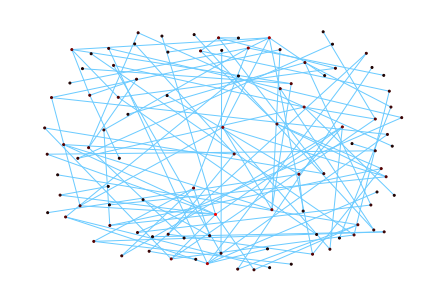

In [11]:
n_nodes = 100
# G = get_updated_central_graph_with_random_edges_type_3(n_nodes=n_nodes, p_add_wire=0.2, p_cut_wire=0.2)
G = get_updated_central_graph_with_random_edges_type_5(n_nodes=n_nodes, p_change=0.9)
draw_network_color_nodes_on_degree(G)

IndexError: invalid index to scalar variable.

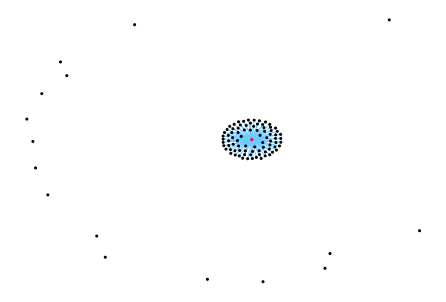

In [264]:
G = get_updated_central_graph_with_random_edges_type_2(n_nodes=100, p_add_wire=0.0, p_cut_wire=0.1)
draw_network_color_nodes_on_degree(G)
np.sum(np.array(G.degree()))[:,1]/n_nodes

In [ ]:
A = np.random.randn(100,100)
print(A)
A = A - np.diag(np.diag(A))
print(A)

[[ 0.43467071  0.79197125 -0.3781086  ...  0.45334995 -0.93030844
  -0.41772448]
 [ 0.36127851  0.3816704   0.66821742 ...  0.7405424   0.00945951
   3.17719939]
 [ 0.92951522 -0.25479215  0.88700962 ...  1.73672784  0.26290593
  -0.92939957]
 ...
 [-0.65989253  0.36049541  0.72930402 ...  1.91995944 -0.76929511
  -0.49836742]
 [ 0.51978517  0.15098095 -0.47464679 ... -1.0981715   1.44811521
   0.55570485]
 [ 0.28808016 -1.52778414  1.30150704 ... -0.15429787  0.73844314
   0.19031351]]
[[ 0.          0.79197125 -0.3781086  ...  0.45334995 -0.93030844
  -0.41772448]
 [ 0.36127851  0.          0.66821742 ...  0.7405424   0.00945951
   3.17719939]
 [ 0.92951522 -0.25479215  0.         ...  1.73672784  0.26290593
  -0.92939957]
 ...
 [-0.65989253  0.36049541  0.72930402 ...  0.         -0.76929511
  -0.49836742]
 [ 0.51978517  0.15098095 -0.47464679 ... -1.0981715   0.
   0.55570485]
 [ 0.28808016 -1.52778414  1.30150704 ... -0.15429787  0.73844314
   0.        ]]


In [242]:
p_add_wire_arr = np.linspace(0.0, 1.0, 100)
degree_std_list = []
degree_mean_list = []
giant_comp_size_list = []

# G_temp = get_updated_central_graph_with_random_edges(n_nodes=100, p_add_wire=0.0, p_cut_wire=0.0)
for p_add_wire in p_add_wire_arr:
    G_temp = get_updated_central_graph_with_random_edges(n_nodes=100, p_add_wire=p_add_wire, p_cut_wire=0.0)
    degree_sequence = sorted((d for n, d in G_temp.degree()), reverse=True)
    degree_std_list.append(np.std(degree_sequence))
    degree_mean_list.append(np.mean(degree_sequence))
    G_temp_GiantComp = G_temp.subgraph(max(nx.connected_components(G_temp), key=len))
    giant_comp_size_list.append(len(G_temp_GiantComp.nodes()))

Based on the type_4 or type_5, changing prob.

In [45]:
# p_change_wire_arr = np.linspace(0.0, 0.3, 200)
p_change_wire_arr = np.linspace(0.0, 1.0, 200)
G_list = []
degree_std_list = []
degree_mean_list = []
giant_comp_size_list = []
average_clustering_list = []
scnd_eigval_list = []
eigval_list = []

# G_temp = get_updated_central_graph_with_random_edges(n_nodes=100, p_add_wire=0.0, p_cut_wire=0.0)
for p_change_wire in p_change_wire_arr:
    G_temp = get_updated_central_graph_with_random_edges_type_5(n_nodes=100, p_change=p_change_wire)
    # G_temp = get_updated_central_graph_with_random_edges(n_nodes=100, p_add_wire=p_change_wire)
    G_list.append(G_temp)
    degree_sequence = sorted((d for n, d in G_temp.degree()), reverse=True)
    degree_std_list.append(np.std(degree_sequence))
    degree_mean_list.append(np.mean(degree_sequence))
    G_temp_GiantComp = G_temp.subgraph(max(nx.connected_components(G_temp), key=len))
    giant_comp_size_list.append(len(G_temp_GiantComp.nodes()))
    average_clustering_list.append(nx.average_clustering(G_temp))

    GG = nx.adjacency_matrix(G_temp).toarray()
    GG = GG - np.diag(np.diag(GG))
    GG = GG + np.eye(len(GG))
    row_sums = GG.sum(axis=1)
    row_sums[row_sums == 0] = 1
    row_sums[np.isinf(row_sums)] = 1
    G2 = GG / row_sums[:, np.newaxis]

    eigVal = np.linalg.eigvals(G2)
    eigVal = np.sort(eigVal)

    # G_scaled = nx.from_numpy_array(G2)
    # eigVal = nx.eigenvector_centrality_numpy(G_scaled)
    # eigVal = np.array(list(eigVal.values()))
    # eigVal = np.sort(eigVal)
    # print(eigVal)

    scnd_eigval_list.append(eigVal[-2])
    eigval_list.append(eigVal)

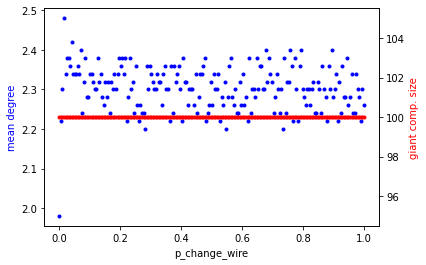

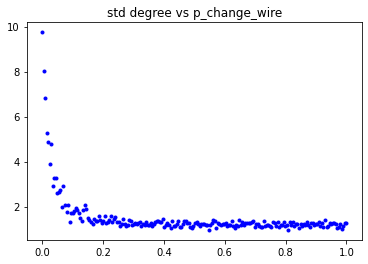

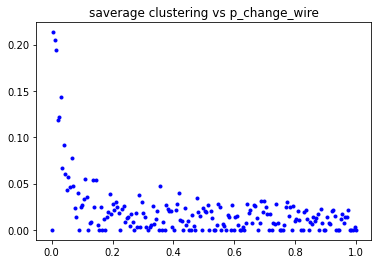

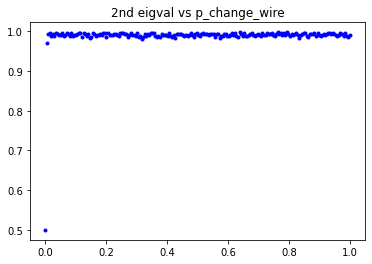

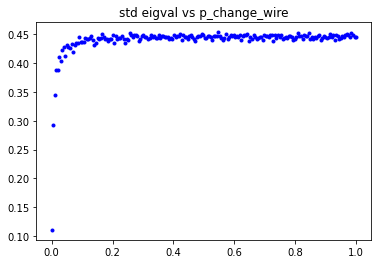

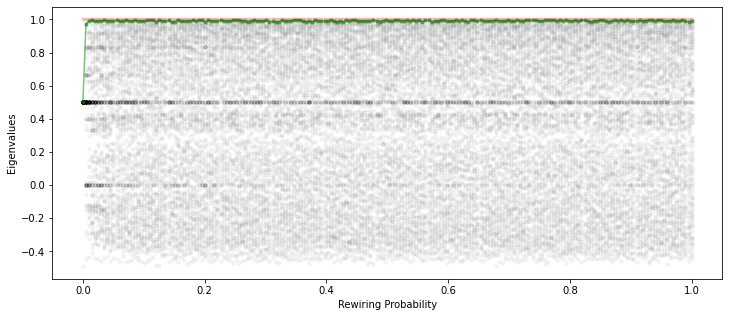

In [48]:
# make a twin yaxis figure and plot degree and giant component size vs p_change_wire
# for a given network
eigval_np = np.array(eigval_list)


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(p_change_wire_arr, degree_mean_list,'.b')
ax1.set_ylabel("mean degree", color='b')
ax2.plot(p_change_wire_arr, giant_comp_size_list,'.r')
ax2.set_ylabel("giant comp. size", color='r')
ax1.set_xlabel("p_change_wire")
plt.show()

# plt.plot(p_change_wire_arr, degree_mean_list,'.b', label="mean degree")
# plt.title("mean degree vs p_change_wire")
# plt.show()

plt.plot(p_change_wire_arr, degree_std_list,'.b', label="std degree")
plt.title("std degree vs p_change_wire")
plt.show()

plt.plot(p_change_wire_arr, average_clustering_list,'.b', label="avg clustering")
plt.title("saverage clustering vs p_change_wire")
plt.show()


plt.plot(p_change_wire_arr, scnd_eigval_list,'.b', label="2nd eigval")
plt.title("2nd eigval vs p_change_wire")
plt.show()


plt.plot(p_change_wire_arr, np.std(eigval_np, axis=1),'.b', label="2nd eigval")
plt.title("std eigval vs p_change_wire")
plt.show()



fig, ax1 = plt.subplots(figsize=(12,5))

plt.plot(p_change_wire_arr,eigval_list,'.k',alpha=0.04,markersize=7)
plt.plot(p_change_wire_arr,np.mean(eigval_np, axis=1),'.r',alpha=0.01)
scnd_eigval = eigval_np[:,-2]
plt.plot(p_change_wire_arr,scnd_eigval,'.-g',alpha=0.5)

first_eigval = eigval_np[:,-1]
plt.plot(p_change_wire_arr,first_eigval,'.-r',alpha=0.1)

plt.xlabel("Rewiring Probability");
plt.ylabel("Eigenvalues");

# plt.xlim([0,.2])
plt.show()

In [13]:
type(eigval_list)
type(p_change_wire_arr)

numpy.ndarray

draw some networks

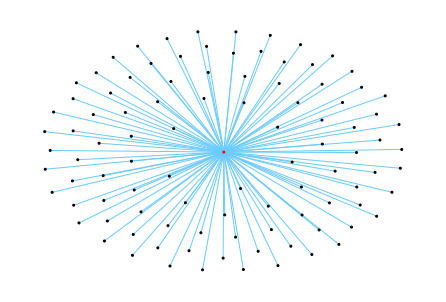

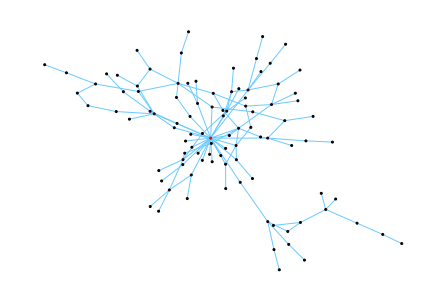

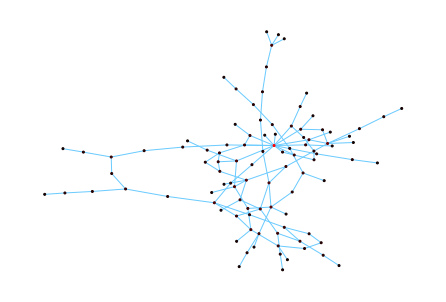

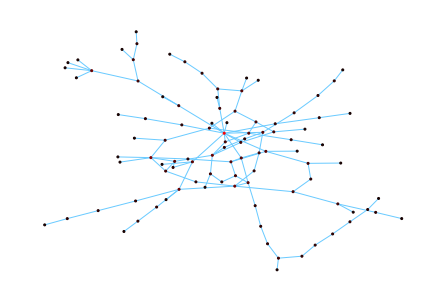

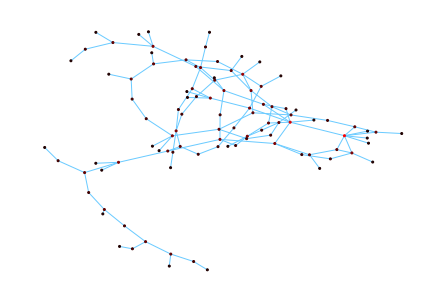

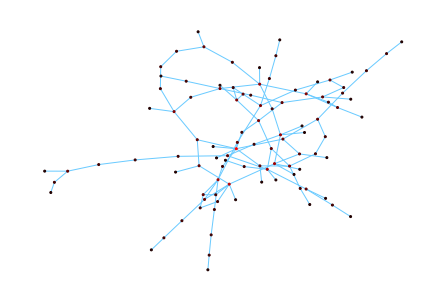

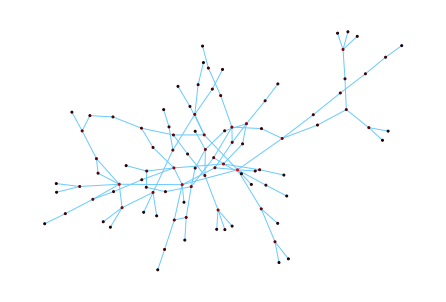

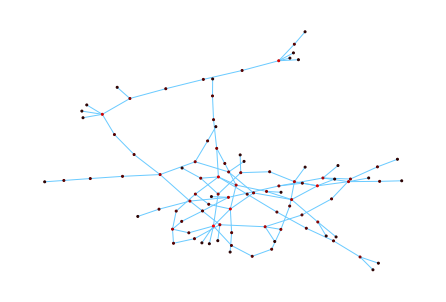

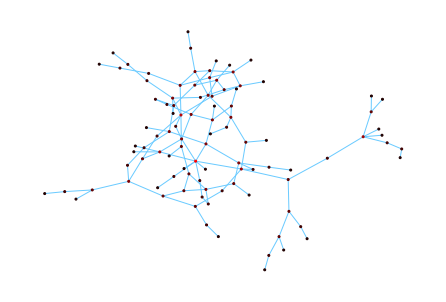

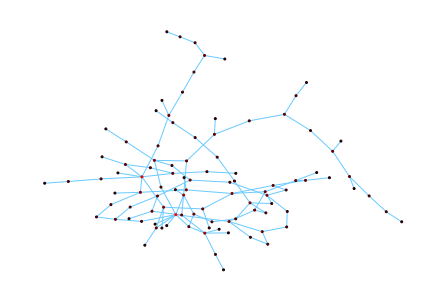

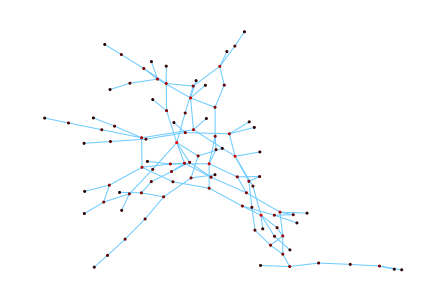

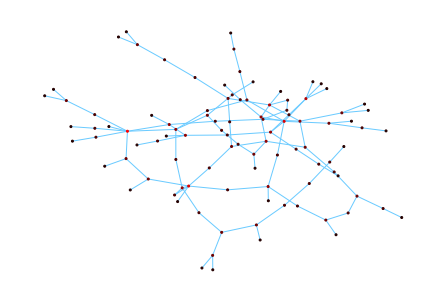

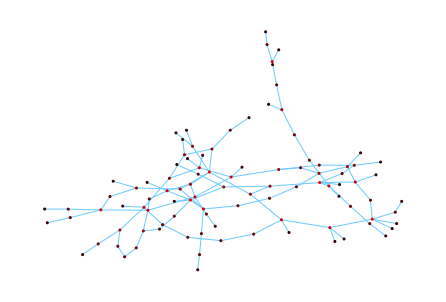

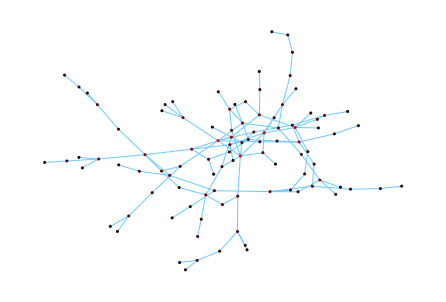

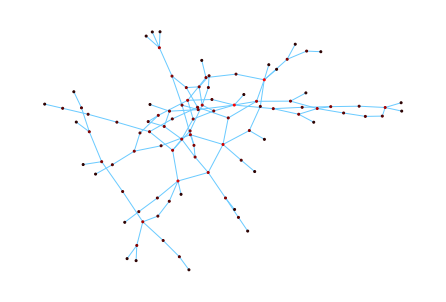

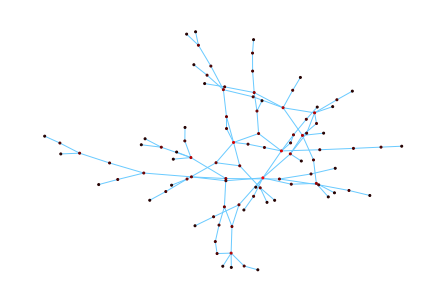

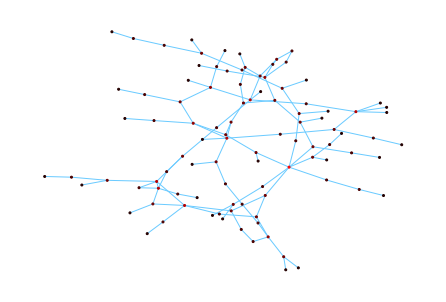

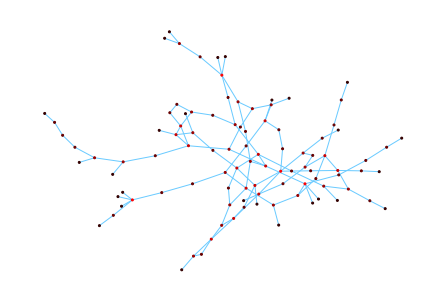

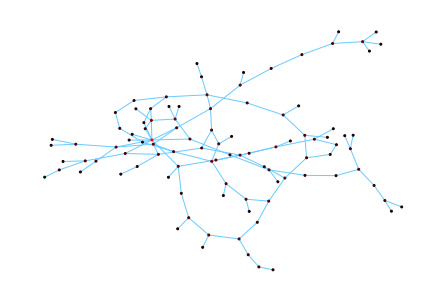

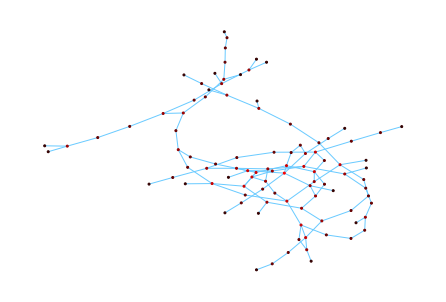

In [315]:
for i in range(len(G_list)):
    G = G_list[i]
    change_prob = p_change_wire_arr[i]
    draw_network_color_nodes_on_degree(G)
    plt.title('Change probability: ' + str(change_prob)
    plt.show()

In [130]:
G = get_updated_central_graph_with_random_edges_type_4(n_nodes=100, p_change=0.3)
np.mean(np.array(G.degree())[:,1])

15.72

mean deg:  6.0
n_nodes:  7


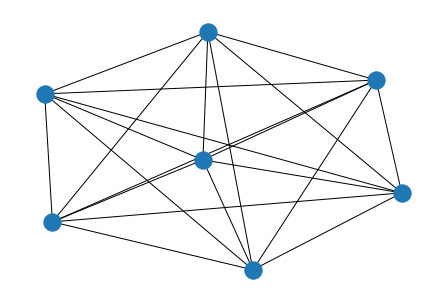

In [ ]:
G_temp = get_updated_central_graph_with_random_edges(n_nodes=7, p_add_wire=2.0)
nx.draw(G_temp)
degree_sequence = sorted((d for n, d in G_temp.degree()), reverse=True)
print("mean deg: ", np.mean(degree_sequence))
print("n_nodes: ", len(G_temp.nodes))

In [119]:
plt.plot(p_add_wire_arr)
# GG = get_updated_central_graph_with_random_edges(100,1)
# nx.draw(GG)
# degree
plt.plot(degree_std_list)

NameError: name 'p_add_wire_arr' is not defined

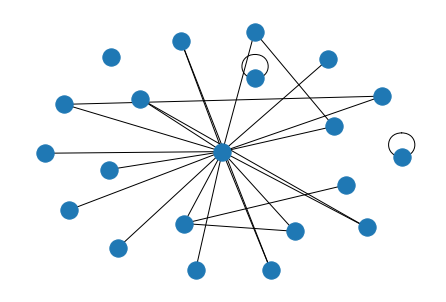

<bound method Graph.adjacency of <networkx.classes.graph.Graph object at 0x7efebc18a940>>

In [ ]:
nx.draw(G2B, pos2B)#, **options)
plt.show()
G2B.adjacency

G2: Average Deg. Dist.:  1.6
G2: Standard Deviation of Deg. Dist.:  7.889233169326408


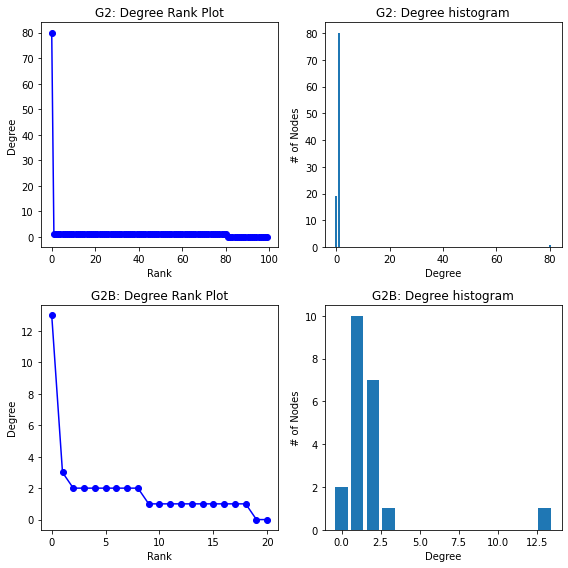

G2B: Average Deg. Dist.:  1.9047619047619047
G2B: Standard Deviation of Deg. Dist.:  2.58023184459887


In [ ]:
G2 = G
degree_sequence = sorted((d for n, d in G2.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(2,2)

ax0 = fig.add_subplot(axgrid[0, 0])
ax0.plot(degree_sequence, "b-", marker="o")
ax0.set_title("G2: Degree Rank Plot")
ax0.set_ylabel("Degree")
ax0.set_xlabel("Rank")

ax1 = fig.add_subplot(axgrid[0, 1])
ax1.bar(*np.unique(degree_sequence, return_counts=True))
ax1.set_title("G2: Degree histogram")
ax1.set_xlabel("Degree")
ax1.set_ylabel("# of Nodes")

print("G2: Average Deg. Dist.: ", str(np.mean(degree_sequence)))
print("G2: Standard Deviation of Deg. Dist.: ", str(np.std(degree_sequence)))

# calculate and plot the degree for the second random graph
degree_sequence = sorted((d for n, d in G2B.degree()), reverse=True)
dmax = max(degree_sequence)

ax2 = fig.add_subplot(axgrid[1, 0])
ax2.plot(degree_sequence, "b-", marker="o")
ax2.set_title("G2B: Degree Rank Plot")
ax2.set_ylabel("Degree")
ax2.set_xlabel("Rank")

ax3 = fig.add_subplot(axgrid[1, 1])
ax3.bar(*np.unique(degree_sequence, return_counts=True))
ax3.set_title("G2B: Degree histogram")
ax3.set_xlabel("Degree")
ax3.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

print("G2B: Average Deg. Dist.: ", str(np.mean(degree_sequence)))
print("G2B: Standard Deviation of Deg. Dist.: ", str(np.std(degree_sequence)))

G1: Average Deg. Dist.:  1.9607843137254901
G1: Standard Deviation of Deg. Dist.:  6.793771034929575
p_cut_wire_scaled:  0.8818342151675486  mean_adjc:  0.4536


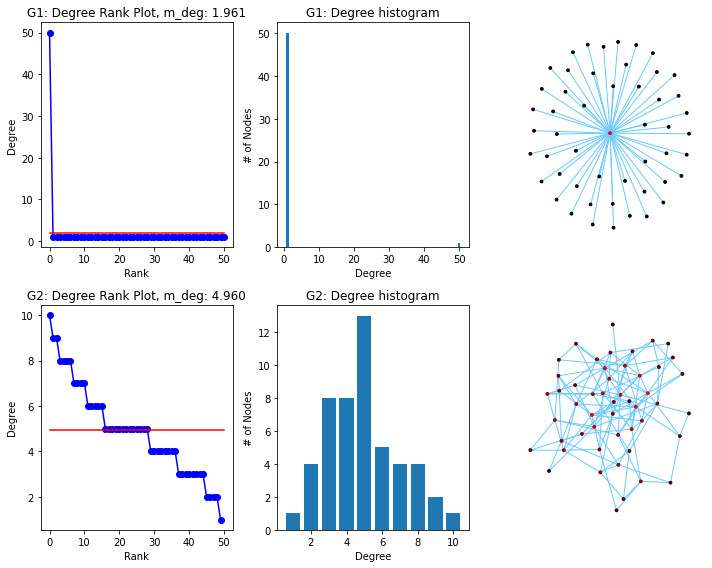

G2: Average Deg. Dist.:  4.96
G2: Standard Deviation of Deg. Dist.:  2.029384143034531


In [73]:
n_nodes = 50

G1 = nx.star_graph(n_nodes)
degree_sequence = sorted((d for n, d in G1.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(10, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(2,3)

ax0_0 = fig.add_subplot(axgrid[0, 0])
ax0_0.plot(degree_sequence, "b-", marker="o")
ax0_0.plot(np.array((0, n_nodes)), np.array((np.mean(degree_sequence), np.mean(degree_sequence))), "r-")
ax0_0.set_title(f"G1: Degree Rank Plot, m_deg: %1.3f" %np.mean(degree_sequence))
ax0_0.set_ylabel("Degree")
ax0_0.set_xlabel("Rank")

ax0_1 = fig.add_subplot(axgrid[0, 1])
ax0_1.bar(*np.unique(degree_sequence, return_counts=True))
ax0_1.set_title("G1: Degree histogram")
ax0_1.set_xlabel("Degree")
ax0_1.set_ylabel("# of Nodes")

ax0_2 = fig.add_subplot(axgrid[0, 2])
draw_network_color_nodes_on_degree(G1, ax0_2)

print("G1: Average Deg. Dist.: ", str(np.mean(degree_sequence)))
print("G1: Standard Deviation of Deg. Dist.: ", str(np.std(degree_sequence)))


# ====================================================================================================

G2 = get_updated_central_graph_with_random_edges_type_3(n_nodes=n_nodes, p_add_wire=0.1, p_cut_wire=0.4)

# calculate and plot the degree for the second random graph
degree_sequence = sorted((d for n, d in G2.degree()), reverse=True)
dmax = max(degree_sequence)

ax1_0 = fig.add_subplot(axgrid[1, 0])
ax1_0.plot(degree_sequence, "b-", marker="o")
ax1_0.set_title(f"G2: Degree Rank Plot, m_deg: %1.3f" %np.mean(degree_sequence))
ax1_0.plot(np.array((0, n_nodes)), np.array((np.mean(degree_sequence), np.mean(degree_sequence))), "r-")
ax1_0.set_ylabel("Degree")
ax1_0.set_xlabel("Rank")

ax1_1 = fig.add_subplot(axgrid[1, 1])
ax1_1.bar(*np.unique(degree_sequence, return_counts=True))
ax1_1.set_title("G2: Degree histogram")
ax1_1.set_xlabel("Degree")
ax1_1.set_ylabel("# of Nodes")

ax1_2 = fig.add_subplot(axgrid[1, 2])
draw_network_color_nodes_on_degree(G2, ax1_2)

fig.tight_layout()
plt.show()

print("G2: Average Deg. Dist.: ", str(np.mean(degree_sequence)))
print("G2: Standard Deviation of Deg. Dist.: ", str(np.std(degree_sequence)))

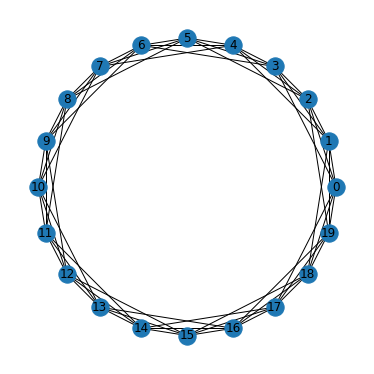

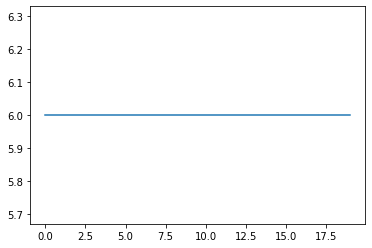

In [37]:
def gen_even_k_reg_network(n_nodes=10, k_reg = 4):
    # assert if k_reg is even, show a warning if it is odd
    if(k_reg%2 == 1):
        print("WARNING: k_reg is odd. It should be even.")
    assert k_reg%2 == 0, "K_reg is odd. It should be even" # k_reg should be even

    G_null = nx.empty_graph(n_nodes)
    # make a loop over the nodes and connect them with the next k_reg nodes
    for i_node in range(n_nodes):
        # add edges between the node and the next k_reg nodes
        for j_node in range(i_node-int(np.ceil(k_reg/2)), i_node+int(np.ceil(k_reg/2))+1):
            if (j_node == i_node):
                continue
            # make a link between i_node and mod(i_node,n_nodes)
            G_null.add_edge(i_node, j_node%n_nodes)

    G_k_reg = G_null.copy()
    return G_k_reg

G_k_reg = gen_even_k_reg_network(n_nodes=20, k_reg = 6)

# calculate and plot the degree for the second random graph
degree_sequence = sorted((d for n, d in G_k_reg.degree()), reverse=True)

# draw the graph and the degree distribution
fig = plt.figure("Degree of a random graph", figsize=(5, 5))
nx.draw_circular(G_k_reg, with_labels=True)
plt.show()

plt.plot(degree_sequence);


In [ ]:
G_k_reg = nx.random_regular_graph(3, n_nodes)
# G_k_reg = nx.circular_ladder_graph(n=n_nodes, offsets = [5], create_using=None)
pos = nx.circular_layout(G_k_reg)
nx.draw_networkx(G_k_reg, pos=pos)
# nx.draw_circular(G_k_reg, )
plt.show()


plt.plot(np.array(G_k_reg.degree())[:, 1])